In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox

# Set style
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [2]:

class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')
        df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'}, inplace=True)
        df.drop(['dteday', 'instant'], axis=1, inplace=True)

        # Creating time-based features
        df['payday'] = df['timestamp'].dt.is_month_end.astype(int)
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas'] = df['timestamp'].apply(lambda x: 1 if x.month == 12 and x.day >= 20 else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear

        # Creating rush hour feature
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_day_ratio = train_df.groupby('day_of_week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_week_ratio = train_df.groupby('week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_month_ratio = train_df.groupby('month').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_season_ratio = train_df.groupby('season').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_weekend_ratio = train_df.groupby('weekend').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_working_day_ratio = train_df.groupby('working_day').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))

        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Now use these ratios wherever needed for working day and weekend conditions
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping original target columns
        train_df.drop(['casual', 'registered'], axis=1, inplace=True)
        val_df.drop(['casual', 'registered'], axis=1, inplace=True)

        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()


        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'].fillna(False, inplace=True)
        val_df['sigma_3_outlier'].fillna(False, inplace=True)


        return train_df.drop_duplicates(), val_df.drop_duplicates()

        

        return train_df.drop_duplicates(), val_df.drop_duplicates()
    
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df.drop('timestamp', axis=1, inplace=True)

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        return train_df, val_df


In [3]:

def inverse_boxcox(y_transformed, lambda_value):
    return (y_transformed * lambda_value + 1) ** (1 / lambda_value) - 1 if lambda_value != 0 else np.exp(y_transformed) - 1

In [4]:

# Load data
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)


Loading data from /Users/lawrence/Documents/PYTHON/saga_tech_test_2025/hour.csv


In [5]:

# Check for missing data
null_counts = hour_processed_df.isnull().sum()
print(null_counts[null_counts > 0])


Series([], dtype: int64)


In [6]:
# Prepare data
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_1304/1637802544.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_1304/1637802544.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_day_ratio = train_df.groupby('day_

In [7]:
train_df.columns

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'payday',
       'day', 'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'working_day', 'weekend', 'moonphase', 'quarter', 'christmas',
       'day_of_year', 'rush_hour', 'total_registered_ratio', 'hour_ratio',
       'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio',
       'month_ratio', 'season_ratio', 'sigma_3_outlier'],
      dtype='object')

In [8]:

# Features and target
target = 'count'
# Preprocessing pipeline
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'moonphase', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'working_day_or_weekend_ratio']
categorical_columns = ['sigma_3_outlier','season', 'year', 'month', 'hour', 'holiday', 'weekday', 'weathersit', 'payday', 'day', 'week', 'working_day', 'weekend', 'quarter', 'rush_hour']

features = numeric_columns + categorical_columns

In [9]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ],
    remainder='passthrough',
    n_jobs=-1
)

# LightGBM regressor pipeline
reg1 = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", lgb.LGBMRegressor(
        verbosity=-1, 
    ))
])

reg1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed', 'year_sin',
                                                   'year_cos', 'month_sin',
                                                   'month_cos', 'day_sin',
                                                   'day_cos', 'hour_sin',
                                                   'hour_cos', 'moonphase',
                                                   'total_registered_rati...
                                                   'week_ratio', 'month_ratio',
                                                   'season_ratio',
                                                   'working_day_or_weekend_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sigma_3_outlier', 'season',
                                                   'year', 'month', 'hour',
                                                   'holiday', 'weekday',
                                                   'weathersit', 'payday',
                                                   'day', 'week', 'working_day',
                                                   'weekend', 'quarter',
                                                   'rush_hour'])])),
                ('regressor', LGBMRegressor(verbosity=-1))])

In [10]:
# Log1p transformation
X_train = train_df[features]
y_train, lambda_value = boxcox(train_df['count'] + 1)

# Set parameters for LightGBM
params = {
    'regressor__num_leaves': 35,  
    'regressor__learning_rate': 0.1,  
    'regressor__n_estimators': 5000, 
}

reg1.set_params(**params)

# Fit model
reg1.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed', 'year_sin',
                                                   'year_cos', 'month_sin',
                                                   'month_cos', 'day_sin',
                                                   'day_cos', 'hour_sin',
                                                   'hour_cos', 'moonphase',
                                                   'total_registered_rati...
                                                   'season_ratio',
                                                   'working_day_or_weekend_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sigma_3_outlier', 'season',
                                                   'year', 'month', 'hour',
                                                   'holiday', 'weekday',
                                                   'weathersit', 'payday',
                                                   'day', 'week', 'working_day',
                                                   'weekend', 'quarter',
                                                   'rush_hour'])])),
                ('regressor',
                 LGBMRegressor(n_estimators=5000, num_leaves=35,
                               verbosity=-1))])

In [11]:
# Predict and transform back from log1p
X_val = val_df[features]
y_val = val_df[target]
y_pred = reg1.predict(X_val)
y_pred_inv = inverse_boxcox(y_pred, lambda_value)

# Metrics
mse = mean_squared_error(y_val, y_pred_inv)
rmse = np.sqrt(mse)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred_inv)))

logging.info(f"RMSE: {rmse}, RMSLE: {rmsle}")

/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-08 19:24:38,324 - INFO - RMSE: 68.66401103478361, RMSLE: 0.38334601865270607


2025-03-07 23:00:35,197 - INFO - RMSE: 71.85258105027408, RMSLE: 0.3757949515903717 - with outlier predicition


2025-03-07 23:03:01,821 - INFO - RMSE: 68.74544440235637, RMSLE: 0.3770531882387551 - without

it worked!! 2025-03-08 00:24:45,603 - INFO - RMSE: 66.27669649948662, RMSLE: 0.36959531828424996 outlier future prediction with day of week cool


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13903 entries, 0 to 13902
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season                        13903 non-null  int64  
 1   year                          13903 non-null  int32  
 2   month                         13903 non-null  int32  
 3   hour                          13903 non-null  int64  
 4   holiday                       13903 non-null  int64  
 5   weekday                       13903 non-null  int64  
 6   workingday                    13903 non-null  int64  
 7   weathersit                    13903 non-null  int64  
 8   temp                          13903 non-null  float64
 9   atemp                         13903 non-null  float64
 10  hum                           13903 non-null  float64
 11  windspeed                     13903 non-null  float64
 12  count                         13903 non-null  int64  
 13  p

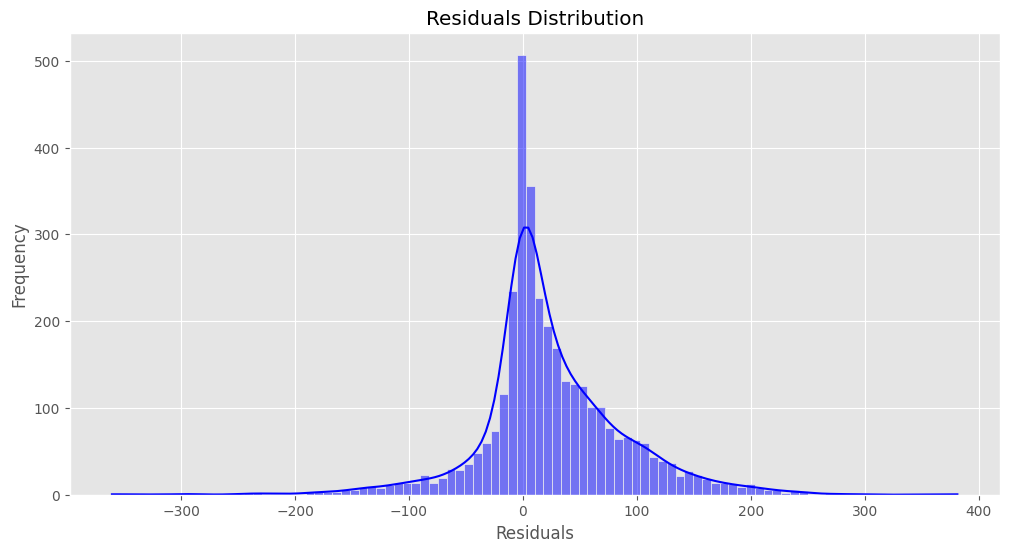

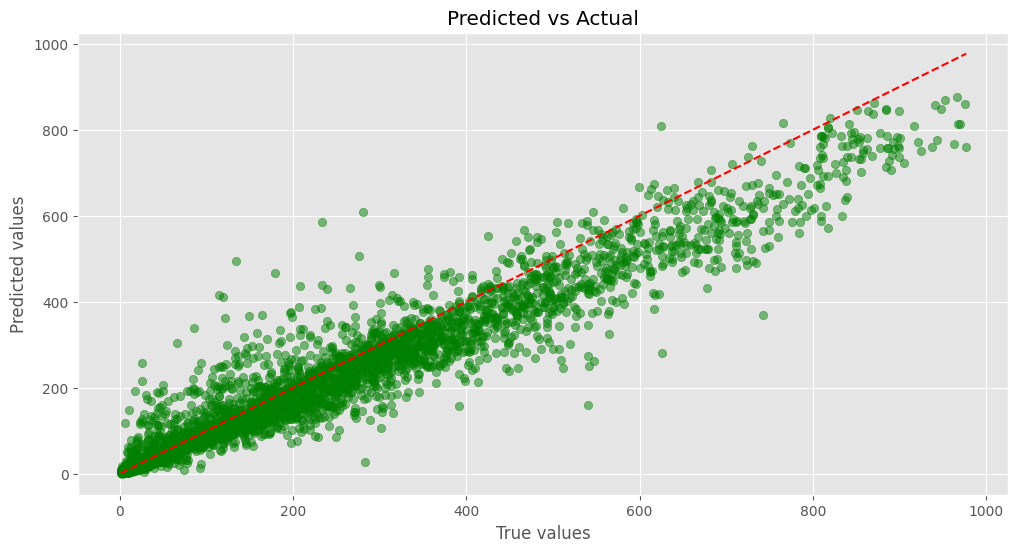

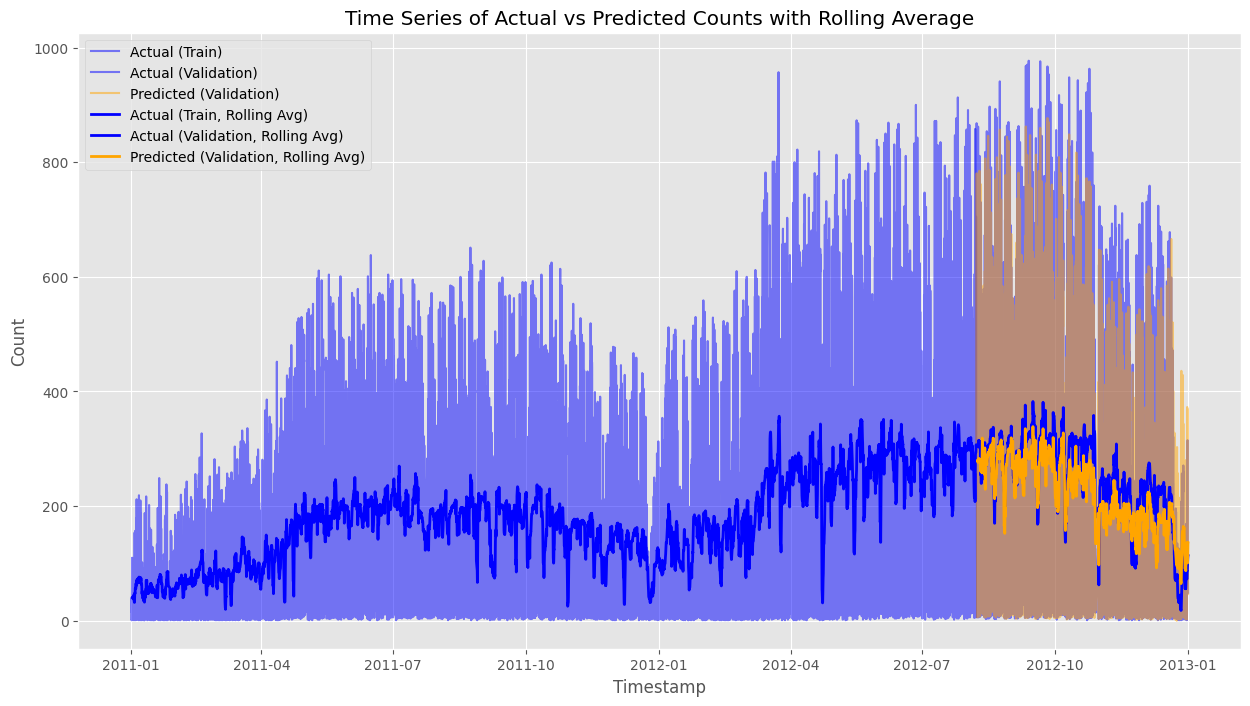

In [13]:
# Recreate the timestamp for training data
train_df['timestamp'] = pd.to_datetime({
	'year': train_df['year'], 
	'month': train_df['month'], 
	'day': train_df['day_of_month']
}) + pd.to_timedelta(train_df['hour'], unit='h')

val_df['timestamp'] = pd.to_datetime({
	'year': val_df['year'], 
	'month': val_df['month'], 
	'day': val_df['day_of_month']
}) + pd.to_timedelta(val_df['hour'], unit='h')

# Residuals and diagnostics
residuals = y_val - y_pred_inv
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_inv, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

# Time series plot with rolling average
plt.figure(figsize=(15, 8))
plt.plot(train_df['timestamp'], train_df[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_val, label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_pred_inv, label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(train_df['timestamp'], train_df[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], y_val.rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], pd.Series(y_pred_inv).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average')
plt.legend()
plt.show()


In [14]:
reduced_features = ['hour',
 'atemp',
 'hour_ratio',
 'temp',
 'hour_sin',
 'year',
 'year_sin',
 'rush_hour',
 'hour_cos',
 'workingday',
 'weathersit',
 'day_of_week',
 'day',
 'hum',
 'day_of_year',
 'day_ratio',
 'weekday']

In [15]:
# Features and target
target = 'count'

# Split reduced_features into numeric and categorical
numeric_columns = ['atemp', 'hour_ratio', 'temp', 'hour_sin', 'year_sin', 
                  'hour_cos', 'hum', 'day_ratio']
                  
categorical_columns = ['hour', 'year', 'rush_hour', 'workingday', 'weathersit', 
                      'day_of_week', 'day', 'day_of_year', 'weekday']

# Use reduced_features directly
features = reduced_features

In [16]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ],
    remainder='passthrough',
    n_jobs=-1
)

# LightGBM regressor pipeline
reg1 = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", lgb.LGBMRegressor(
        verbosity=-1, 
    ))
])

reg1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['atemp', 'hour_ratio',
                                                   'temp', 'hour_sin',
                                                   'year_sin', 'hour_cos',
                                                   'hum', 'day_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'year', 'rush_hour',
                                                   'workingday', 'weathersit',
                                                   'day_of_week', 'day',
                                                   'day_of_year',
                                                   'weekday'])])),
                ('regressor', LGBMRegressor(verbosity=-1))])

In [17]:
# Log1p transformation
X_train = train_df[features]
y_train, lambda_value = boxcox(train_df['count'] + 1)

# Set parameters for LightGBM
params = {
    'regressor__num_leaves': 35,  
    'regressor__learning_rate': 0.1,  
    'regressor__n_estimators': 5000, 
}

reg1.set_params(**params)

# Fit model
reg1.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['atemp', 'hour_ratio',
                                                   'temp', 'hour_sin',
                                                   'year_sin', 'hour_cos',
                                                   'hum', 'day_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'year', 'rush_hour',
                                                   'workingday', 'weathersit',
                                                   'day_of_week', 'day',
                                                   'day_of_year',
                                                   'weekday'])])),
                ('regressor',
                 LGBMRegressor(n_estimators=5000, num_leaves=35,
                               verbosity=-1))])

In [18]:
# Predict and transform back from log1p
X_val = val_df[features]
y_val = val_df[target]
y_pred = reg1.predict(X_val)
y_pred_inv = inverse_boxcox(y_pred, lambda_value)

# Metrics
mse = mean_squared_error(y_val, y_pred_inv)
rmse = np.sqrt(mse)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred_inv)))

logging.info(f"RMSE: {rmse}, RMSLE: {rmsle}")

/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-08 19:24:55,181 - INFO - RMSE: 64.88052094916597, RMSLE: 0.39309963843256057


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13903 entries, 0 to 13902
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   season                        13903 non-null  int64         
 1   year                          13903 non-null  int32         
 2   month                         13903 non-null  int32         
 3   hour                          13903 non-null  int64         
 4   holiday                       13903 non-null  int64         
 5   weekday                       13903 non-null  int64         
 6   workingday                    13903 non-null  int64         
 7   weathersit                    13903 non-null  int64         
 8   temp                          13903 non-null  float64       
 9   atemp                         13903 non-null  float64       
 10  hum                           13903 non-null  float64       
 11  windspeed                   

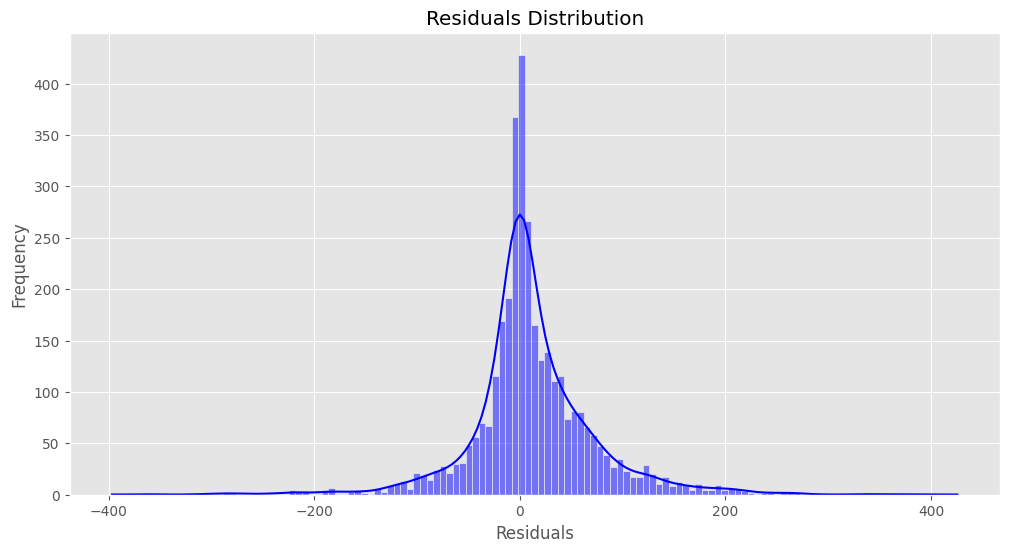

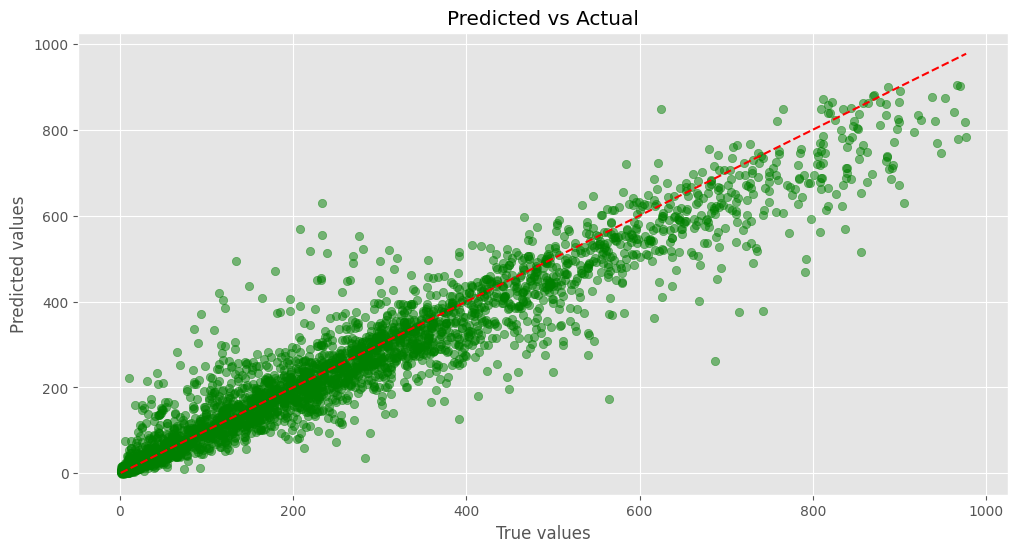

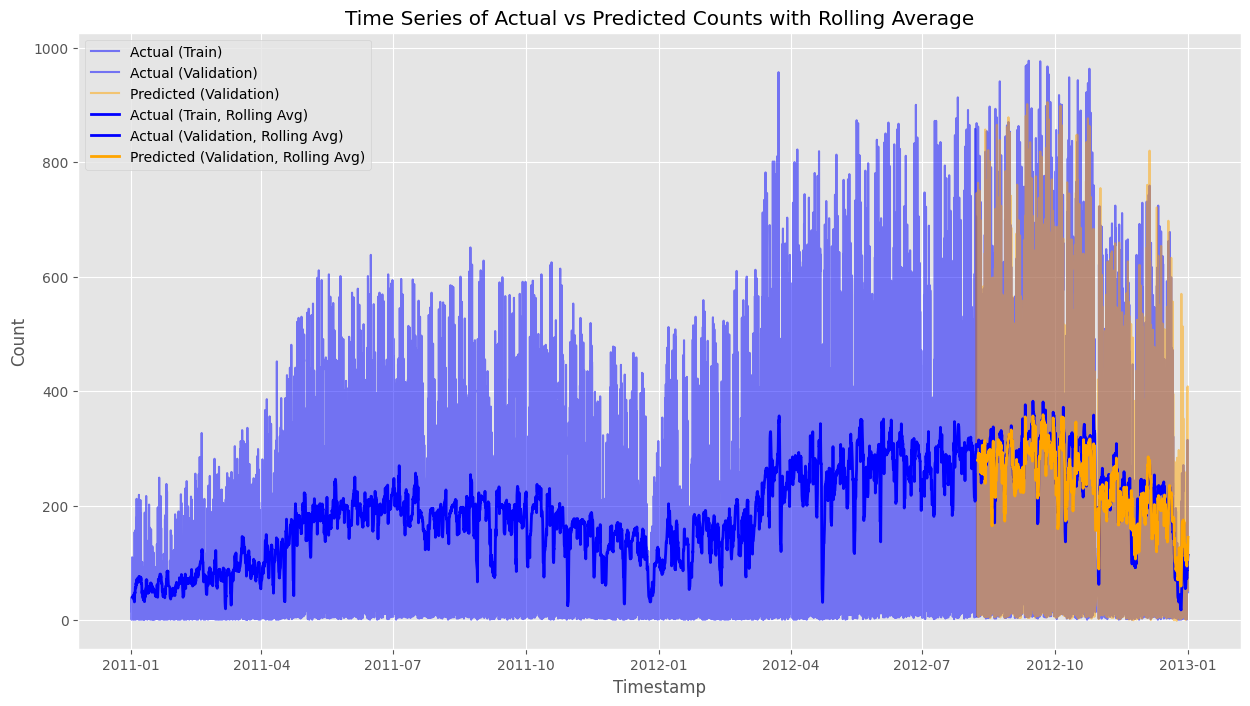

In [20]:
# Recreate the timestamp for training data
train_df['timestamp'] = pd.to_datetime({
	'year': train_df['year'], 
	'month': train_df['month'], 
	'day': train_df['day_of_month']
}) + pd.to_timedelta(train_df['hour'], unit='h')

val_df['timestamp'] = pd.to_datetime({
	'year': val_df['year'], 
	'month': val_df['month'], 
	'day': val_df['day_of_month']
}) + pd.to_timedelta(val_df['hour'], unit='h')

# Residuals and diagnostics
residuals = y_val - y_pred_inv
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_inv, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

# Time series plot with rolling average
plt.figure(figsize=(15, 8))
plt.plot(train_df['timestamp'], train_df[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_val, label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_pred_inv, label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(train_df['timestamp'], train_df[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], y_val.rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], pd.Series(y_pred_inv).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import logging

# Define inverse BoxCox transformation
def inverse_boxcox(y_transformed, lambda_value):
    return (y_transformed * lambda_value + 1) ** (1 / lambda_value) - 1 if lambda_value != 0 else np.exp(y_transformed) - 1

# Create a logger
logging.basicConfig(level=logging.INFO)

# Your feature list - corrected to match actual column names
features_in_importance_order = ['hour', 'atemp', 'hour_ratio', 'temp', 'hour_sin', 'year', 'year_sin', 'rush_hour', 
                                'hour_cos', 'working_day', 'weathersit', 'day_of_week', 'day', 'hum', 'day_of_year', 
                                'day_ratio', 'season', 'week_ratio', 'month_cos', 'weekend', 
                                'windspeed', 'week', 'working_day_or_weekend_ratio', 'holiday', 'day_sin', 
                                'moonphase', 'day_cos', 'month']

# Define features and target
target = 'count'

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'moonphase', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'working_day_or_weekend_ratio']

categorical_label_encode_columns = ['season', 'year', 'month', 'hour', 'day_of_week', 'weathersit','day', 'week', 'quarter']

categorical_one_hot_columns = ['sigma_3_outlier', 'holiday', 'payday', 'working_day', 'weekend', 'rush_hour']


# Combine features into one list
features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

# Preprocessing pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# One-hot encoding for categorical columns
categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Label encoding for other categorical columns
categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns)
    ],
    remainder='drop',
    n_jobs=-1
)

# Log1p transformation
y_train, lambda_value = boxcox(train_df['count'] + 1)

# Set parameters for LightGBM
params = {
    'num_leaves': 35,  
    'learning_rate': 0.1,  
    'n_estimators': 5000, 
}

# Track best metrics
best_rmse = float("inf")
best_rmsle = float("inf")
best_features = None

# Create a list to store all results
all_results = []

# First run with all features
n_features = len(features_in_importance_order)
selected_features = features_in_importance_order.copy()

# Evaluate performance by progressively removing features from the end
for i in range(0, len(features_in_importance_order)):
    if i > 0:
        # Remove the last feature for each iteration after the first
        selected_features = features_in_importance_order[:-i]
    
    # Check if all selected features exist in the dataset
    valid_features = [f for f in selected_features if f in train_df.columns]
    if len(valid_features) != len(selected_features):
        logging.warning(f"Some features not found in dataset: {set(selected_features) - set(valid_features)}")
        selected_features = valid_features
    
    # Get training data with selected features
    X_train = train_df[selected_features]
    print(f"Using {len(selected_features)} features: {selected_features}")
    
    # Fit the preprocessor
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Create and fit LightGBM model
    model = lgb.LGBMRegressor(**params, verbosity=-1)
    model.fit(X_train_processed, y_train)
    
    # Process validation data and make predictions
    X_val = val_df[selected_features]
    y_val = val_df[target]
    X_val_processed = preprocessor.transform(X_val)
    y_pred = model.predict(X_val_processed)
    
    # Apply inverse transformation
    y_pred_inv = inverse_boxcox(y_pred, lambda_value)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred_inv)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred_inv)))
    
    # Store results
    all_results.append({
        'n_features': len(selected_features),
        'features': selected_features.copy(),
        'rmse': rmse,
        'rmsle': rmsle
    })
    
    # Log the metrics
    logging.info(f"Features: {len(selected_features)} | RMSE: {rmse:.4f} | RMSLE: {rmsle:.4f}")
    
    # Track the best performing feature subset
    if rmse < best_rmse:
        best_rmse = rmse
        best_rmsle = rmsle
        best_features = selected_features.copy()

# Sort results by RMSE to find optimal feature count
all_results.sort(key=lambda x: x['rmse'])
best_result = all_results[0]

logging.info(f"Best Features ({best_result['n_features']}): {best_result['features']} | Best RMSE: {best_result['rmse']:.4f} | Best RMSLE: {best_result['rmsle']:.4f}")

Using 28 features: ['hour', 'atemp', 'hour_ratio', 'temp', 'hour_sin', 'year', 'year_sin', 'rush_hour', 'hour_cos', 'working_day', 'weathersit', 'day_of_week', 'day', 'hum', 'day_of_year', 'day_ratio', 'season', 'week_ratio', 'month_cos', 'weekend', 'windspeed', 'week', 'working_day_or_weekend_ratio', 'holiday', 'day_sin', 'moonphase', 'day_cos', 'month']


ValueError: A given column is not a column of the dataframe

In [27]:
X_train.columns

Index(['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'moonphase', 'total_registered_ratio', 'hour_ratio', 'day_ratio',
       'week_ratio', 'month_ratio', 'season_ratio',
       'working_day_or_weekend_ratio', 'season', 'year', 'month', 'hour',
       'day_of_week', 'weathersit', 'day', 'week', 'quarter',
       'sigma_3_outlier', 'holiday', 'payday', 'working_day', 'weekend',
       'rush_hour'],
      dtype='object')

In [ ]:

# Convert the sparse matrix to a dense format if needed
X_train_processed_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed

# Get feature names for both numeric and categorical columns
numeric_feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(numeric_columns)
categorical_feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_columns)

# Combine the names of the features
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Create DataFrame with feature names
X_train_df = pd.DataFrame(X_train_processed_dense, columns=all_feature_names)

print('all_feature_names:', all_feature_names)

In [ ]:

# Track best metrics
best_rmse = float("inf")
best_rmsle = float("inf")
best_features = None

# Evaluate performance with each subset of features
for n_features in range(1, len(features_in_importance_order) + 1):
    selected_features = features_in_importance_order[:n_features]
    X_train_reduced = X_train[selected_features]
    
    # Fit the model
    reg1.fit(X_train_reduced, y_train)
    
    # Predict and inverse transform log1p
    X_val = val_df[selected_features]
    y_val = val_df[target]
    y_pred = reg1.predict(X_val)
    y_pred_inv = inverse_boxcox(y_pred, lambda_value)
    
    # Metrics calculation
    mse = mean_squared_error(y_val, y_pred_inv)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred_inv)))
    
    # Log the metrics
    logging.info(f"Features: {selected_features} | RMSE: {rmse} | RMSLE: {rmsle}")
    
    # Track the best performing feature subset
    if rmse < best_rmse:
        best_rmse = rmse
        best_rmsle = rmsle
        best_features = selected_features

logging.info(f"Best Features: {best_features} | Best RMSE: {best_rmse} | Best RMSLE: {best_rmsle}")